   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

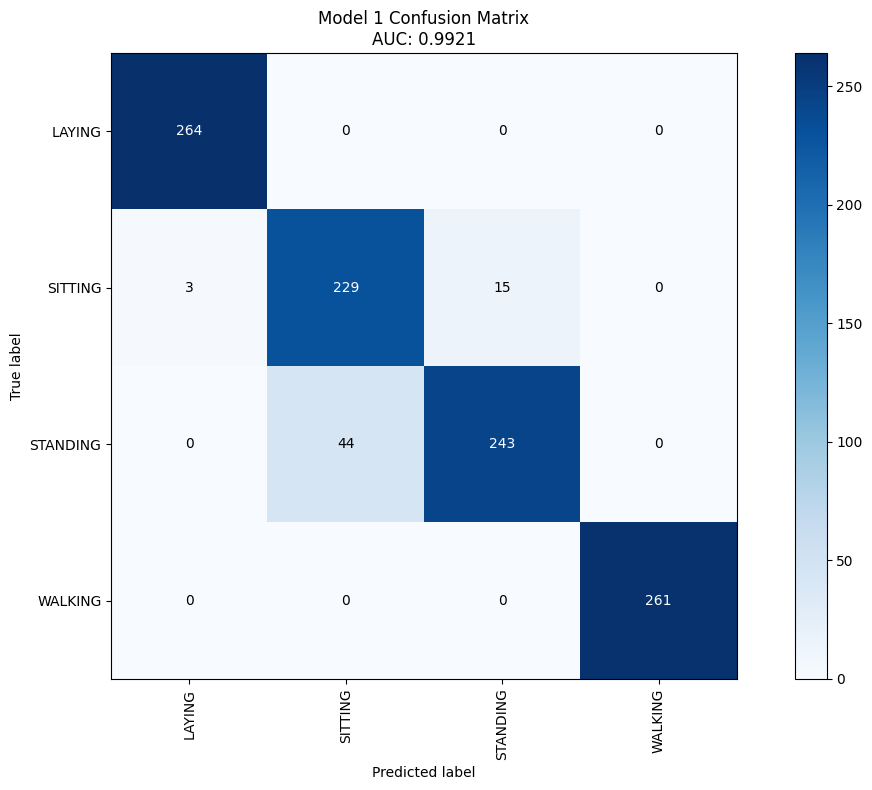

In [24]:
import json
import mlflow
import argparse
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")



# # Get the arugments we need to avoid fixing the dataset path in code
# parser = argparse.ArgumentParser()
# parser.add_argument("--data", type=str, required=True, help='Dataset path')
# args = parser.parse_args()
# mlflow.autolog()
# mlflow.log_param("hello_param", "action_classifier")

# data_csv=pd.read_csv(args.data)
data_csv = pd.read_csv("human-activity-recognition-with-smartphones/train.csv")


print(data_csv.head())
print(data_csv["Activity"].unique())
print('Number of duplicates in data : ',sum(data_csv.duplicated()))
print('Total number of missing values in train : ', data_csv.isna().values.sum())

data_df = data_csv[~data_csv['Activity'].isin(['WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])]
print(data_df.Activity.value_counts())

# plt.figure(figsize=(10,8))
# plt.title('Barplot of Activity')
# sns.countplot(data_df.Activity)
# plt.xticks(rotation=0)
# plt.show()

# le = LabelEncoder()
# data_df['Activity'] = le.fit_transform(data_df.Activity)
# print(data_df['Activity'].sample(5))
# original_labels = le.inverse_transform([0,1,2,3])      # Only to know which one corresponds to each number

y_data_df = data_df.Activity
x_data_df = data_df.drop(['subject', 'Activity'], axis=1)
# x_data_df= x_data_df.iloc[:,0:2]


# Set the number of models and splits
num_models = 1

for i in range(num_models):
    #Split the data and keep 20% back for testing later
    X_train, X_test, Y_train, Y_test = train_test_split(x_data_df, y_data_df, test_size=0.20, random_state=42)
    print("Train length", len(X_train))
    print("Test length", len(X_test))

    retrain_requested = False
    if retrain_requested:
        # Create Logistic Regression Classifier
        print("Retraining with Logistic Regression Model")
        parameters = {'C':np.arange(10,61,20), 'penalty':['l2','l1']}
        lr_classifier_rs = LogisticRegression()
    else:
        # Create Decision Tree Classifier
        print("Training with Decision Tree Model")   
        parameters = {'weights': ['uniform', 'distance'],'n_neighbors': np.arange(1, 21)}
        lr_classifier = KNeighborsClassifier()
    lr_classifier_rs = RandomizedSearchCV(lr_classifier, param_distributions=parameters, cv=5,random_state = 42)
    lr_classifier_rs.fit(X_train, Y_train)
    y_pred = lr_classifier_rs.predict(X_test)

    lr_accuracy = accuracy_score(y_true=Y_test, y_pred=y_pred)
    print(f'Model {i+1} - Accuracy: {lr_accuracy}')
    # mlflow.log_metric(f'Model_{i+1}_Accuracy:',lr_accuracy)

    # Calculate AUC
    Y_scores = lr_classifier_rs.predict_proba(X_test)
    #print(Y_scores)
    auc = roc_auc_score(Y_test, Y_scores, multi_class='ovr')
    print(f'Model {i+1} - AUC: {auc}')
    # mlflow.log_metric(f'Model_{i+1}_AUC:', auc)

    ## Make predictions
    # output_class = lr_classifier_rs.predict(X_test.iloc[0:2])
    output_class = lr_classifier_rs.predict(X_test.iloc[[1]])
    # output_class_label = original_labels[output_class]
    # Convert the array to a list and then to JSON
    activity_json = json.dumps(output_class.tolist())
    # Print the predicted class
    print(f"Predicted class: {activity_json}")
    
    # function to plot confusion matrix
    def plot_confusion_matrix(cm,lables, i):
        # labels  = original_labels[lables] 
        fig, ax = plt.subplots(figsize=(12,8)) # for plotting confusion matrix as image
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=lables, yticklabels=lables,
        ylabel='True label',
        xlabel='Predicted label')
        plt.xticks(rotation = 90)
        plt.title(f'Model {i+1} Confusion Matrix\nAUC: {auc:.4f}')
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.show()

    # Plot the confusion matrix
    cm = confusion_matrix(Y_test.values,y_pred)
    plot_confusion_matrix(cm, np.unique(y_pred), i)  # plotting confusion matrix

In [3]:
## Make predictions
# output_class = lr_classifier_rs.predict(X_test.iloc[0:2])
output_class = lr_classifier_rs.predict(X_test)
# output_class_label = original_labels[output_class]
# Convert the array to a list and then to JSON
activity_json = json.dumps(output_class.tolist())
# Print the predicted class
print(f"Predicted class: {activity_json}")

Predicted class: ["LAYING", "LAYING", "WALKING", "STANDING", "LAYING", "WALKING", "SITTING", "STANDING", "WALKING", "WALKING", "SITTING", "STANDING", "STANDING", "LAYING", "LAYING", "WALKING", "WALKING", "SITTING", "STANDING", "STANDING", "STANDING", "STANDING", "STANDING", "LAYING", "STANDING", "SITTING", "LAYING", "LAYING", "LAYING", "WALKING", "STANDING", "WALKING", "LAYING", "LAYING", "SITTING", "LAYING", "STANDING", "STANDING", "WALKING", "WALKING", "LAYING", "SITTING", "STANDING", "STANDING", "SITTING", "LAYING", "STANDING", "WALKING", "LAYING", "STANDING", "STANDING", "STANDING", "STANDING", "LAYING", "STANDING", "SITTING", "LAYING", "WALKING", "SITTING", "LAYING", "WALKING", "SITTING", "WALKING", "SITTING", "LAYING", "SITTING", "SITTING", "SITTING", "SITTING", "WALKING", "WALKING", "WALKING", "STANDING", "STANDING", "LAYING", "WALKING", "STANDING", "SITTING", "LAYING", "STANDING", "STANDING", "STANDING", "STANDING", "LAYING", "WALKING", "WALKING", "SITTING", "LAYING", "WALKING"

In [87]:
X_test.iloc[0:1,0:10]


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X
855,0.279031,-0.006192,-0.123125,-0.992093,-0.924358,-0.900717,-0.993573,-0.92258,-0.896295,-0.927058


In [88]:
#write code for convert the X_test data
X_test.iloc[0:1,0:10].to_json('data.json', orient='records')





In [89]:
X_test.iloc[0:1].columns.tolist()
# X_test.iloc[:,0:2]
X_test.iloc[0:2].index.tolist()

[855, 4933]

In [25]:
test_csv = pd.read_csv("human-activity-recognition-with-smartphones/test.csv")

print(test_csv["Activity"].unique())
print('Number of duplicates in data : ',sum(test_csv.duplicated()))
print('Total number of missing values in train : ', test_csv.isna().values.sum())

test_df = test_csv[~test_csv['Activity'].isin(['WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])]
print(test_df.Activity.value_counts())

y_test_df = test_df.Activity
x_test_df = test_df.drop(['subject', 'Activity'], axis=1)
print(x_test_df.shape)
print(y_test_df.shape)    


['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
Number of duplicates in data :  0
Total number of missing values in train :  0
Activity
LAYING      537
STANDING    532
WALKING     496
SITTING     491
Name: count, dtype: int64
(2056, 561)
(2056,)


In [26]:
ytest_pred = lr_classifier_rs.predict(x_test_df)
test_accuracy = accuracy_score(y_true=y_test_df, y_pred=ytest_pred)
print(f'Test - Accuracy: {test_accuracy}')
# mlflow.log_metric(f'Model_{i+1}_Accuracy:',lr_accuracy)

# Calculate AUC
Ytest_scores = lr_classifier_rs.predict_proba(x_test_df)
#print(Y_scores)
test_auc = roc_auc_score(y_test_df, Ytest_scores, multi_class='ovr')
print(f'Test - AUC: {test_auc}')
# mlflow.log_metric(f'Model_{i+1}_AUC:', auc)

Test - Accuracy: 0.9280155642023347
Test - AUC: 0.9818047293715386


In [110]:
import pandas as pd

# Given DataFrame
df = X_test.iloc[0:3]

# Define the desired columns
desired_columns = df.columns.tolist()

# Create the desired structure
data = {
    "input_data": {
        "columns": desired_columns,
        "index": df[desired_columns].index.tolist(),
        "data": df[desired_columns].values.tolist()
    },
    "params": {}
}

# print(data)
json_string = json.dumps(data, indent=2)
print(json_string)


{
  "input_data": {
    "columns": [
      "tBodyAcc-mean()-X",
      "tBodyAcc-mean()-Y",
      "tBodyAcc-mean()-Z",
      "tBodyAcc-std()-X",
      "tBodyAcc-std()-Y",
      "tBodyAcc-std()-Z",
      "tBodyAcc-mad()-X",
      "tBodyAcc-mad()-Y",
      "tBodyAcc-mad()-Z",
      "tBodyAcc-max()-X",
      "tBodyAcc-max()-Y",
      "tBodyAcc-max()-Z",
      "tBodyAcc-min()-X",
      "tBodyAcc-min()-Y",
      "tBodyAcc-min()-Z",
      "tBodyAcc-sma()",
      "tBodyAcc-energy()-X",
      "tBodyAcc-energy()-Y",
      "tBodyAcc-energy()-Z",
      "tBodyAcc-iqr()-X",
      "tBodyAcc-iqr()-Y",
      "tBodyAcc-iqr()-Z",
      "tBodyAcc-entropy()-X",
      "tBodyAcc-entropy()-Y",
      "tBodyAcc-entropy()-Z",
      "tBodyAcc-arCoeff()-X,1",
      "tBodyAcc-arCoeff()-X,2",
      "tBodyAcc-arCoeff()-X,3",
      "tBodyAcc-arCoeff()-X,4",
      "tBodyAcc-arCoeff()-Y,1",
      "tBodyAcc-arCoeff()-Y,2",
      "tBodyAcc-arCoeff()-Y,3",
      "tBodyAcc-arCoeff()-Y,4",
      "tBodyAcc-arCoeff()-Z,1",
   

In [112]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
# data = json_string

body = str.encode(json.dumps(data))

url = 'https://assignmentsnobin-eaupz.eastus2.inference.ml.azure.com/score'
# Replace this with the primary/secondary key or AMLToken for the endpoint
api_key = 'EaGe52atc2deJoQVH7tfKEBld9Dlnat6'
if not api_key:
    raise Exception("A key should be provided to invoke the endpoint")

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'hac-model-best-2' }

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))


b'["SITTING", "SITTING", "STANDING"]'


In [98]:
import pandas as pd
import requests
import json

# Create a sample DataFrame
# data = {'column1': [1, 2, 3], 'column2': ['A', 'B', 'C']}
# df = pd.DataFrame(data)

# # Convert the DataFrame to JSON
# json_data = df.to_json(orient='records')

# Specify the API endpoint
api_url = 'https://assignmentsnobin-eaupz.eastus2.inference.ml.azure.com/score'

# Include your API key in the headers
# headers = {'x-api-key': 'fuQyYoncLec9wBPB1lTsKaiYfERApn38', 'Content-Type': 'application/json'}

# Make a POST request with the DataFrame data and headers
response = requests.post(api_url, json=json_string)

# Check the response
if response.status_code == 200:
    print("API request successful!")
    print("Response:", response.json())
else:
    print(f"API request failed with status code {response.status_code}")
    print("Response:", response.text)


API request failed with status code 403
Response: key_auth_bad_header_forbidden
Please check this guide to understand why this error code might have been returned 
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-troubleshoot-online-endpoints#http-status-codes



In [10]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

job_name = "gray_store_x3ltwv1lb1"

run_model = Model(
    path=f"azureml://jobs/{job_name}/outputs/artifacts/paths/model/",
    name="run-model-example",
    description="Model created from run.",
    type=AssetTypes.MLFLOW_MODEL,
)
# Uncomment after adding required details above
ml_client.models.create_or_update(run_model)

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://management.azure.com/subscriptions/bf0717bf-dfd1-4019-a2b6-aa46e3899a4d/resourceGroups/assignment-snobin/providers/Microsoft.MachineLearningServices/workspaces/assignmentsnobin/models/run-model-example?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'Accept': 'application/json'
    'x-ms-client-request-id': 'c9d7d030-ab42-11ee-bea4-ac78fc859303'
    'User-Agent': 'azure-ai-ml/1.12.1 azsdk-python-mgmt-machinelearningservices/0.1.0 Python/3.10.11 (Windows-10-10.0.22621-SP0)'
    'Authorization': 'REDACTED'
No body was attached to the request
DEBUG:urllib3.connectionpool:Resetting dropped connection: management.azure.com
DEBUG:urllib3.connectionpool:https://management.azure.com:443 "GET /subscriptions/bf0717bf-dfd1-4019-a2b6-aa46e3899a4d/resourceGroups/assignment-snobin/providers/Microsoft.MachineLearningServices/workspaces/assignmentsnobin/models/run-model-example?api-version=2023-08-01-preview H

Model({'job_name': 'gray_store_x3ltwv1lb1', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'run-model-example', 'description': 'Model created from run.', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/bf0717bf-dfd1-4019-a2b6-aa46e3899a4d/resourceGroups/assignment-snobin/providers/Microsoft.MachineLearningServices/workspaces/assignmentsnobin/models/run-model-example/versions/1', 'Resource__source_path': None, 'base_path': 'c:\\Users\\anton\\myworks\\AI_course_labs\\term2\\Intel&Infra\\assignment\\HAC_tabular', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x000001CD9B5ECEE0>, 'serialize': <msrest.serialization.Serializer object at 0x000001CD9B5ED5D0>, 'version': '1', 'latest_version': None, 'path': 'azureml://subscriptions/bf0717bf-dfd1-4019-a2b6-aa46e3899a4d/resourceGroups/assignment-snobin/workspaces/assignmentsnobin/datastores/workspaceartifactstore/p

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): westus2-0.in.applicationinsights.azure.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): westus2-0.in.applicationinsights.azure.com:443
DEBUG:urllib3.connectionpool:https://westus2-0.in.applicationinsights.azure.com:443 "POST /v2.1/track HTTP/1.1" 200 49
DEBUG:urllib3.connectionpool:https://westus2-0.in.applicationinsights.azure.com:443 "POST /v2.1/track HTTP/1.1" 200 49


In [11]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import logging
logging.basicConfig(level=logging.DEBUG)
from azure.identity import AzureCliCredential, DefaultAzureCredential
credential = AzureCliCredential()

# authenticate
# credential = DefaultAzureCredential()

registered_model_name="run-model-example"

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = 'bf0717bf-dfd1-4019-a2b6-aa46e3899a4d',
    resource_group_name="assignment-snobin",
    workspace_name="assignmentsnobin",
)

# Let's pick the latest version of the model
latest_model_version = max(
    [int(m.version) for m in ml_client.models.list(name=registered_model_name)]
)

print(latest_model_version)
import uuid
# Create a unique name for the endpoint
online_endpoint_name = "credit-endpoint-" + str(uuid.uuid4())[:8]

from azure.ai.ml.entities import ManagedOnlineEndpoint

# define an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is an online endpoint",
    auth_mode="key",
    tags={
        "training_dataset": "credit_defaults",
    },
)

# create the online endpoint
# expect the endpoint to take approximately 2 minutes.

endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

print(
    f'Endpoint "{endpoint.name}" with provisioning state "{endpoint.provisioning_state}" is retrieved'
)

INFO:azure.identity._internal.decorators:AzureCliCredential.get_token succeeded
DEBUG:azure.identity._internal.decorators:[Authenticated account] Client ID: 04b07795-8ddb-461a-bbee-02f9e1bf7b46. Tenant ID: 6f0b9487-4fa8-42a8-aeb4-bf2e2c22d4e8. User Principal Name: Antony-S1@ulster.ac.uk. Object ID (user): 6d19dd59-e001-4be7-9ab3-a071b0ea7ff2
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://management.azure.com/subscriptions/bf0717bf-dfd1-4019-a2b6-aa46e3899a4d/resourceGroups/assignment-snobin/providers/Microsoft.MachineLearningServices/workspaces/assignmentsnobin/models/run-model-example/versions?api-version=REDACTED&listViewType=REDACTED'
Request method: 'GET'
Request headers:
    'Accept': 'application/json'
    'x-ms-client-request-id': '6af8ae73-ab43-11ee-a42d-ac78fc859303'
    'User-Agent': 'azure-ai-ml/1.12.1 azsdk-python-mgmt-machinelearningservices/0.1.0 Python/3.10.11 (Windows-10-10.0.22621-SP0)'
    'Authorization': 'REDACTED'
No body was attached t

1


DEBUG:urllib3.connectionpool:https://management.azure.com:443 "GET /subscriptions/bf0717bf-dfd1-4019-a2b6-aa46e3899a4d/resourceGroups/assignment-snobin/providers/Microsoft.MachineLearningServices/workspaces/assignmentsnobin?api-version=2023-08-01-preview HTTP/1.1" 200 None
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Cache-Control': 'no-cache'
    'Pragma': 'no-cache'
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; charset=utf-8'
    'Content-Encoding': 'REDACTED'
    'Expires': '-1'
    'Vary': 'REDACTED'
    'x-ms-request-id': 'f879f635-2750-4cef-a6de-3c1ad4bb8d35'
    'x-ms-ratelimit-remaining-subscription-reads': '11997'
    'Request-Context': 'REDACTED'
    'x-ms-response-type': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'x-aml-cluster': 'REDACTED'
    'x-request-time': 'REDACTED'
    'x-ms-correlation-request-id': 'REDACTED'
    'x-ms-routing-req

Endpoint "credit-endpoint-2aa35596" with provisioning state "Succeeded" is retrieved


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): westus2-0.in.applicationinsights.azure.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): westus2-0.in.applicationinsights.azure.com:443
DEBUG:urllib3.connectionpool:https://westus2-0.in.applicationinsights.azure.com:443 "POST /v2.1/track HTTP/1.1" 200 49
DEBUG:urllib3.connectionpool:https://westus2-0.in.applicationinsights.azure.com:443 "POST /v2.1/track HTTP/1.1" 200 49
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): westus2-0.in.applicationinsights.azure.com:443
DEBUG:urllib3.connectionpool:https://westus2-0.in.applicationinsights.azure.com:443 "POST /v2.1/track HTTP/1.1" 200 49


In [5]:
!pip show azure-ai-ml

Name: azure-ai-ml


Version: 1.12.1
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: c:\users\anton\myworks\ai_course_labs\term2\intel&infra\week8\practical-8-mlflow-b00912163\production\venv\lib\site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 


In [28]:
from azure.ai.ml.entities import ManagedOnlineDeployment

# Choose the latest version of our registered model for deployment
model = ml_client.models.get(name=registered_model_name, version=latest_model_version)

# define an online deployment
# if you run into an out of quota error, change the instance_type to a comparable VM that is available.\
# Learn more on https://azure.microsoft.com/en-us/pricing/details/machine-learning/.
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_D2as_v4",
    instance_count=1,
)

# create the online deployment
blue_deployment = ml_client.online_deployments.begin_create_or_update(
    blue_deployment
).result()

# blue deployment takes 100% traffic
# expect the deployment to take approximately 8 to 10 minutes.
endpoint.traffic = {"blue": 100}
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

Test the endpoint

In [27]:
import os

# Create a directory to store the sample request file.
deploy_dir = "./deploy"
os.makedirs(deploy_dir, exist_ok=True)

In [29]:
import json
import os

test_csv = pd.read_csv("human-activity-recognition-with-smartphones/test.csv")

print(test_csv["Activity"].unique())
print('Number of duplicates in data : ',sum(test_csv.duplicated()))
print('Total number of missing values in train : ', test_csv.isna().values.sum())

test_df = test_csv[~test_csv['Activity'].isin(['WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])]
print(test_df.Activity.value_counts())

y_test_df = test_df.Activity
x_test_df = test_df.drop(['subject', 'Activity'], axis=1)
print(x_test_df.shape)
print(y_test_df.shape)    


import pandas as pd

# Given DataFrame
df = x_test_df.iloc[0:3]

# Define the desired columns
desired_columns = df.columns.tolist()

# Create the desired structure
data = {
    "input_data": {
        "columns": desired_columns,
        "index": df[desired_columns].index.tolist(),
        "data": df[desired_columns].values.tolist()
    },
    "params": {}
}

# print(data)
json_string = json.dumps(data, indent=2)
print(json_string)

['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
Number of duplicates in data :  0
Total number of missing values in train :  0
Activity
LAYING      537
STANDING    532
WALKING     496
SITTING     491
Name: count, dtype: int64
(2056, 561)
(2056,)
{
  "input_data": {
    "columns": [
      "tBodyAcc-mean()-X",
      "tBodyAcc-mean()-Y",
      "tBodyAcc-mean()-Z",
      "tBodyAcc-std()-X",
      "tBodyAcc-std()-Y",
      "tBodyAcc-std()-Z",
      "tBodyAcc-mad()-X",
      "tBodyAcc-mad()-Y",
      "tBodyAcc-mad()-Z",
      "tBodyAcc-max()-X",
      "tBodyAcc-max()-Y",
      "tBodyAcc-max()-Z",
      "tBodyAcc-min()-X",
      "tBodyAcc-min()-Y",
      "tBodyAcc-min()-Z",
      "tBodyAcc-sma()",
      "tBodyAcc-energy()-X",
      "tBodyAcc-energy()-Y",
      "tBodyAcc-energy()-Z",
      "tBodyAcc-iqr()-X",
      "tBodyAcc-iqr()-Y",
      "tBodyAcc-iqr()-Z",
      "tBodyAcc-entropy()-X",
      "tBodyAcc-entropy()-Y",
      "tBodyAcc-entropy()-Z",
      "tBo

In [30]:
%%writefile {deploy_dir}/sample-request.json
json_string

Writing ./deploy/sample-request.json


In [ ]:
# test the blue deployment with the sample data
ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="hac-model-blue",
    request_file="./deploy/sample-request.json",
)

logs = ml_client.online_deployments.get_logs(
    name="hac-model-blue", endpoint_name=online_endpoint_name, lines=50
)
print(logs)

In [ ]:
##########################
#<save and register model>
##########################
# Registering the model to the workspace
print("Registering the model via MLFlow")
mlflow.sklearn.log_model(
    sk_model=lr_classifier_rs,
    registered_model_name=registered_model_name,
    artifact_path=registered_model_name
)

# # Saving the model to a file
print("Saving the model via MLFlow")
mlflow.sklearn.save_model(
    sk_model=lr_classifier_rs,
    path=os.path.join(registered_model_name, "hac_model"),
)
